In [5]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

In [31]:
#cargamos los datos
data = pd.read_csv('data.csv')
data = data[data['Country/Region'].isin(['Ecuador'])]
infectados = (data.iloc[:, 5])
recuperados = (data.iloc[:, 6])
formatoFecha = '%Y-%m-%d'
fecha = data['Date']
data['Date'] = fecha.map(lambda x: (datetime.strptime(x, formatoFecha) - datetime.strptime('2020-01-22', formatoFecha)).days)
dias = list(data['Date'])

In [7]:
def prediccion(beta, gamma, data, rec):
    predict_range = 150
    new_index = dias
    size = len(new_index)
    def SIR(t, y):
        S = y[0]
        I = y[1]
        R = y[2]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    extended_actual = np.concatenate((data.values, [None] * (size - len(data.values))))
    return new_index, extended_actual, solve_ivp(SIR, [0, size], [70000, rec, 0], t_eval=np.arange(0, size, 1))


In [39]:
def train(rec):
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(infectados),
            method='TNC',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = prediccion(beta, gamma, infectados, rec)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        }, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title('Dias')
        df.plot(ax=ax)

In [51]:
def trainRecuperados(rec):
        optimal = minimize(
            loss,
            [0.001, 0.001],
            args=(infectados),
            method='TNC',
            bounds=[(0.00000001, 0.4), (0.00000001, 0.4)]
        )
        beta, gamma = optimal.x
        new_index, extended_actual, prediction = prediccion(beta, gamma, recuperados, rec)
        df = pd.DataFrame({
            'Actual': extended_actual,
            'S': prediction.y[0],
            'I': prediction.y[1],
            'R': prediction.y[2]
        }, index=new_index)
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title('Dias')
        df.plot(ax=ax)

In [45]:
def loss(point, data):
    size = len(data)
    beta, gamma = point
    def SIR(t, y):
        S = y[2]
        I = y[1]
        R = y[0]
        return [-beta*S*I, beta*S*I-gamma*I, gamma*I]
    solution = solve_ivp(SIR, [0, size], [70000, 0, 0], t_eval=np.arange(0, size, 1), vectorized=True)
    return np.sqrt(np.mean((solution.y[1] - data)**2))

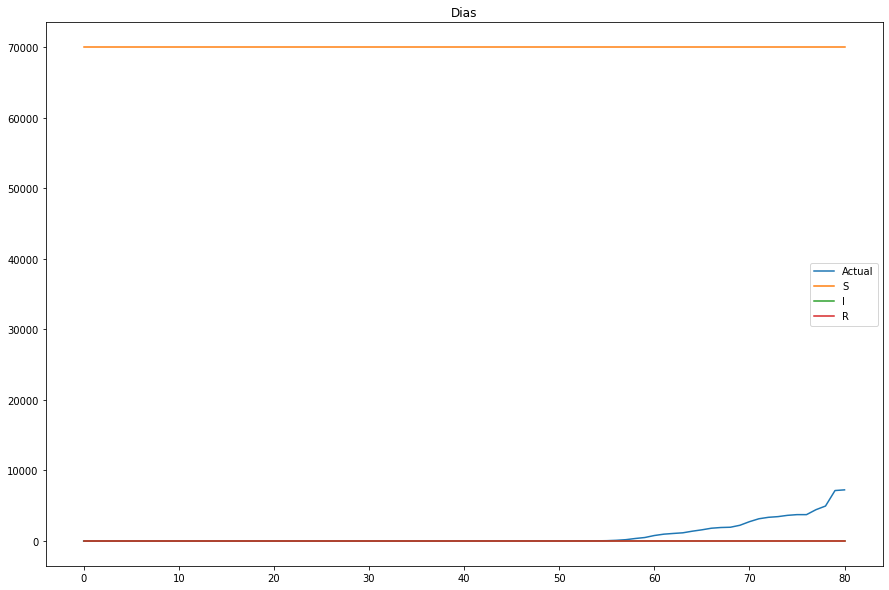

In [48]:
train(rec = 0)

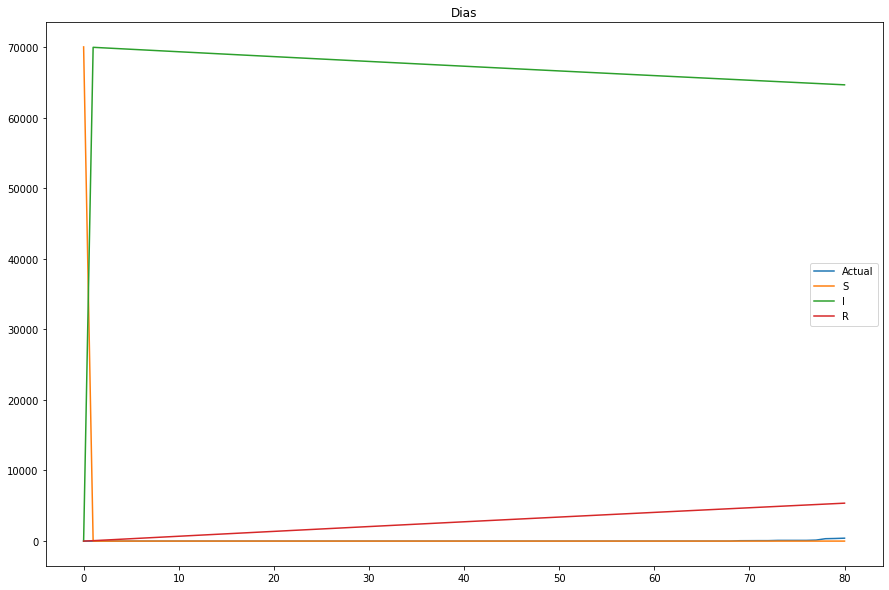

In [55]:
trainRecuperados(rec = 1)

#### Prevalencia e Incidencia

In [18]:
personas = 16500000
indicencia = sum(infectados) / personas
print('Incidencia: ',indicencia)

actual = 7466
prevalencia = (actual / personas) * max(dias)
print('Prevalencia:', prevalencia)

Incidencia:  0.003890060606060606
Prevalencia: 0.03619878787878788
